In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("reviews/Roborock_reviews.csv")

In [3]:
data.head()

,Rating,Review_title,Product_review
0,5.0 out of 5 stars,BEST ROB VAC (in this price range),I purchased the Roborock E4 over a month ago.
1,4.0 out of 5 stars,A True LIFE SAVER!!!!,I've only noticed a few minor issues with this...
2,5.0 out of 5 stars,Great value robot vac,We have had this little vac for almost two mo...
3,5.0 out of 5 stars,My new helper,"First of all, I used to be a person who saw a ..."
4,1.0 out of 5 stars,Gets stuck on EVERYTHING. Constant supervision...,Grabbed this on Cyber Monday and was really e...


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Rating          1367 non-null   object
 1   Review_title    1378 non-null   object
 2   Product_review  1378 non-null   object
dtypes: object(3)
memory usage: 32.4+ KB


In [5]:
data.dropna(inplace = True)

In [6]:
def strip_rating(r):
    return str(r).split('.')[0]

In [7]:
data['Rating'] = data['Rating'].apply(strip_rating)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1367 entries, 0 to 1366
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Rating          1367 non-null   object
 1   Review_title    1367 non-null   object
 2   Product_review  1367 non-null   object
dtypes: object(3)
memory usage: 42.7+ KB


In [9]:
data.head()

,Rating,Review_title,Product_review
0,5,BEST ROB VAC (in this price range),I purchased the Roborock E4 over a month ago.
1,4,A True LIFE SAVER!!!!,I've only noticed a few minor issues with this...
2,5,Great value robot vac,We have had this little vac for almost two mo...
3,5,My new helper,"First of all, I used to be a person who saw a ..."
4,1,Gets stuck on EVERYTHING. Constant supervision...,Grabbed this on Cyber Monday and was really e...


In [10]:
def review_sentiments(Rating):
    if int(Rating) > 3:
        return 'Positive'
    elif int(Rating) == 3:
        return 'Neutral'
    elif int(Rating) < 3:
        return 'Negative'
    else:
        return "Error occured"

In [11]:
data['Sentiments'] = data['Rating'].apply(review_sentiments)
data.head()

,Rating,Review_title,Product_review,Sentiments
0,5,BEST ROB VAC (in this price range),I purchased the Roborock E4 over a month ago.,Positive
1,4,A True LIFE SAVER!!!!,I've only noticed a few minor issues with this...,Positive
2,5,Great value robot vac,We have had this little vac for almost two mo...,Positive
3,5,My new helper,"First of all, I used to be a person who saw a ...",Positive
4,1,Gets stuck on EVERYTHING. Constant supervision...,Grabbed this on Cyber Monday and was really e...,Negative


Text(0.5, 1.0, 'Distribution of Reviews Category')

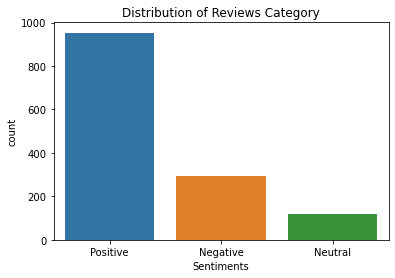

In [12]:
sns.countplot(data['Sentiments']).set_title("Distribution of Reviews Category")   #distribution of the reviews
#kindle_df